In [59]:
import os
import time
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, resize
from PIL import Image
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True

# Paths
basedir1 = "/home/shared/data_raw/LAC/semantics_map1_preset1"
basedir2 = "/home/shared/data_raw/LAC/semantics_map2_preset12_auto"

# Semantic mapping (RGB)
semantic_colors = {
    (250, 170, 30): 0,  # Fiducials
    (108, 59, 42): 1,  # Rocks
    (110, 190, 160): 2,  # Lander
    (81, 0, 81): 3,  # Ground
    (0, 0, 0): 4,  # Sky
}

color_map = np.zeros((256, 256, 3), dtype=np.uint8)
color_to_index = {tuple(k): v for k, v in semantic_colors.items()}


def rgb_to_class(mask_rgb):
    mask_np = np.array(mask_rgb)
    class_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    for rgb, idx in color_to_index.items():
        class_mask[np.all(mask_np == rgb, axis=-1)] = idx
    return class_mask


class SegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, downscale_factor=2):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.downscale_factor = downscale_factor

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        mask = cv2.imread(self.mask_paths[idx])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        H, W, _ = img.shape
        H_ds = (H // self.downscale_factor) // 32 * 32
        W_ds = (W // self.downscale_factor) // 32 * 32

        img_resized = resize(Image.fromarray(img), (H_ds, W_ds))
        mask_resized = resize(Image.fromarray(rgb_to_class(mask)), (H_ds, W_ds), interpolation=Image.NEAREST)

        img_tensor = to_tensor(img_resized)
        mask_tensor = torch.from_numpy(np.array(mask_resized)).long()

        return img_tensor, mask_tensor


cameras = ["FrontLeft", "FrontRight", "Left", "Right"]

def get_paths(basedirs):
    mask_paths_train, mask_paths_test = [], []
    img_paths_train, img_paths_test = [], []

    for basedir in basedirs:
        all_filenames = sorted([f"{c}/{f}" for c in cameras for f in os.listdir(os.path.join(basedir, c)) if f.endswith(".png")], key=lambda x: int(x.split("/")[-1].split(".")[0]))
        np.random.seed(42)
        # np.random.shuffle(all_filenames)
        split_idx = int(0.8 * len(all_filenames))
        train_files = all_filenames[:split_idx]
        test_files = all_filenames[split_idx:]
        img_paths_train.extend([os.path.join(basedir, f) for f in train_files])
        img_paths_test.extend([os.path.join(basedir, f) for f in test_files])
        mask_paths_train.extend([
            os.path.join(basedir, f.replace(f.split("/")[0], f.split("/")[0] + "_semantic")) for f in train_files
        ])
        mask_paths_test.extend([
            os.path.join(basedir, f.replace(f.split("/")[0], f.split("/")[0] + "_semantic")) for f in test_files
        ])
    return img_paths_train, mask_paths_train, img_paths_test, mask_paths_test

img_paths_train, mask_paths_train, img_paths_test, mask_paths_test = get_paths([basedir1, basedir2])

train_ds = SegDataset(img_paths_train, mask_paths_train)
test_ds = SegDataset(img_paths_test, mask_paths_test)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=24, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=4, num_workers=24, pin_memory=True)

model_names = ["Unet", "UnetPlusPlus", "FPN", "PSPNet", "DeepLabV3", "DeepLabV3Plus", "Linknet", "MAnet", "PAN"]

device = torch.device("cuda")
results = {}

name = "UnetPlusPlus"

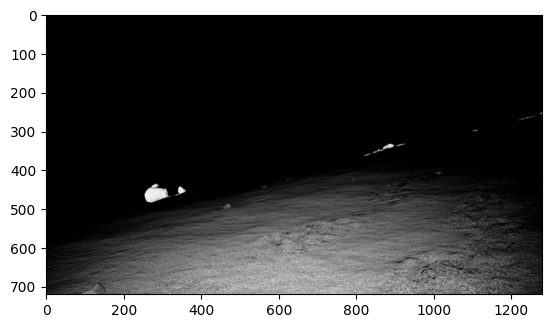

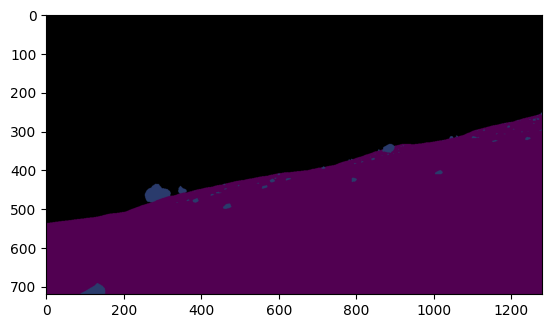

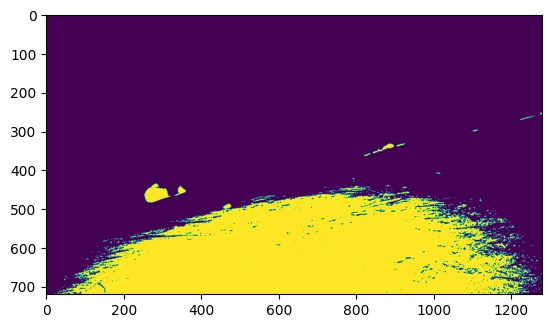

In [60]:
img, mask = cv2.imread(img_paths_test[-1]), cv2.imread(mask_paths_test[-1])
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()
# Mask based on intensity
mask_intensity = np.mean(img, axis=-1) > 50
plt.imshow(mask_intensity)

In [62]:
print(f"\n==> Training {name}")
model = (
    getattr(smp, name)(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=5,
    )
    .to(device)
    .to(memory_format=torch.channels_last)
)


==> Training UnetPlusPlus


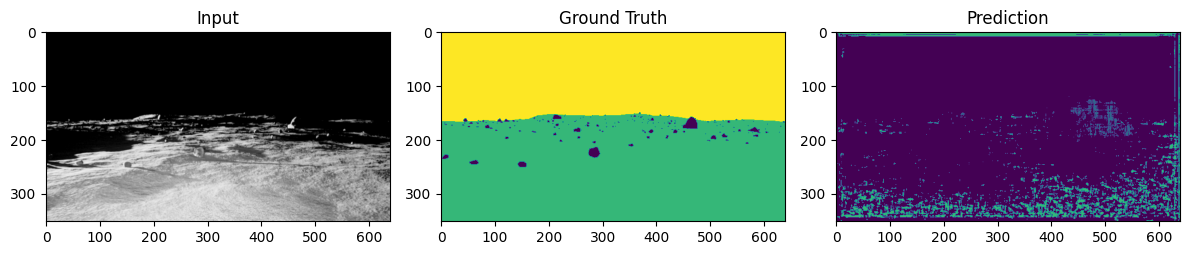

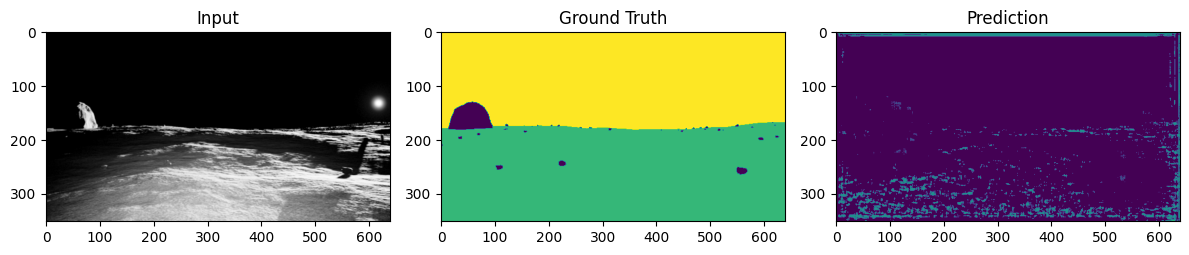

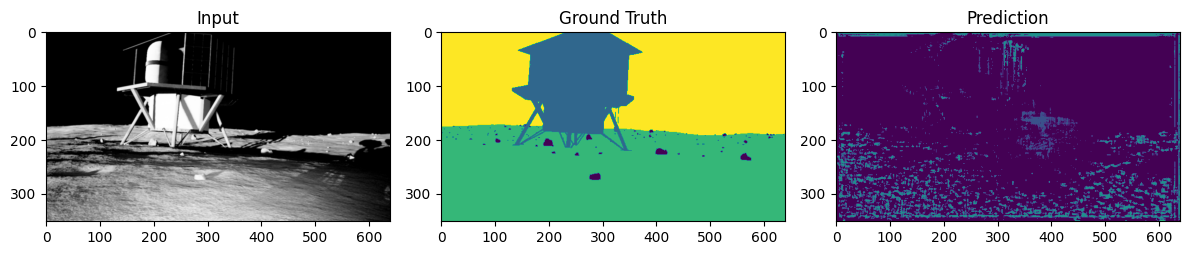

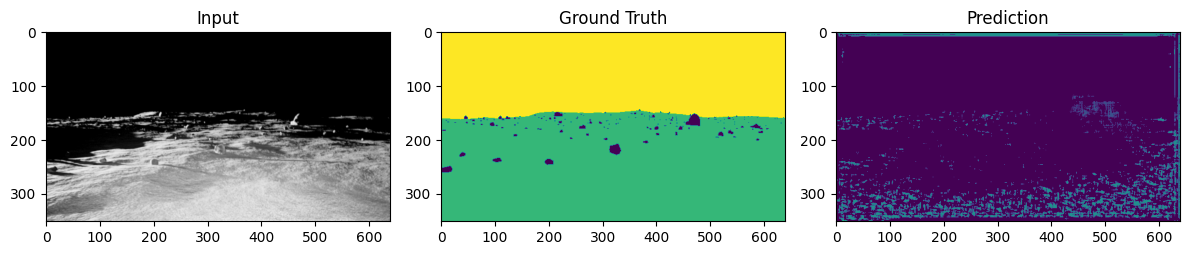

In [63]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        img = img.to(device)
        out = model(img)
        pred = out.argmax(1).squeeze().cpu()

        for i in range(pred.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(img[i].permute(1, 2, 0).cpu())
            plt.title("Input")
            plt.subplot(1, 3, 2)
            plt.imshow(mask[i].squeeze())
            plt.title("Ground Truth")
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i])
            plt.title("Prediction")
            plt.tight_layout()
            plt.show()
        break

In [64]:
class_weights = torch.tensor([1.0, 5.0, 1.0, 1.0, 1.0], device=device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler("cuda")

model.train()
for epoch in range(5):
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
eval_loss = 0
start_time = time.time()
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        eval_loss += loss.item()
total_time = time.time() - start_time
secs_per_image = total_time / (len(test_loader.dataset))

results[name] = {"test_loss": eval_loss / len(test_loader), "secs_per_image": secs_per_image}

# Report
print("\n=== Results ===")
for model_name, metrics in results.items():
    print(f"{model_name:15s} | Loss: {metrics['test_loss']:.4f} | Secs/img: {metrics['secs_per_image']:.4f}")

100%|██████████| 4947/4947 [03:00<00:00, 27.48it/s]


Epoch 1: Loss = 0.1002


100%|██████████| 4947/4947 [03:05<00:00, 26.74it/s]


Epoch 2: Loss = 0.0413


100%|██████████| 4947/4947 [03:10<00:00, 25.93it/s]


Epoch 3: Loss = 0.0328


100%|██████████| 4947/4947 [03:01<00:00, 27.30it/s]


Epoch 4: Loss = 0.0285


100%|██████████| 4947/4947 [03:00<00:00, 27.35it/s]


Epoch 5: Loss = 0.0253


100%|██████████| 1237/1237 [00:27<00:00, 44.94it/s]


=== Results ===
UnetPlusPlus    | Loss: 0.0571 | Secs/img: 0.0056


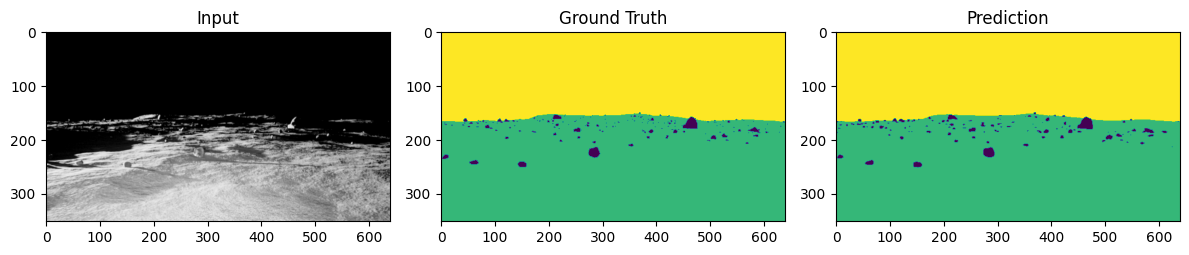

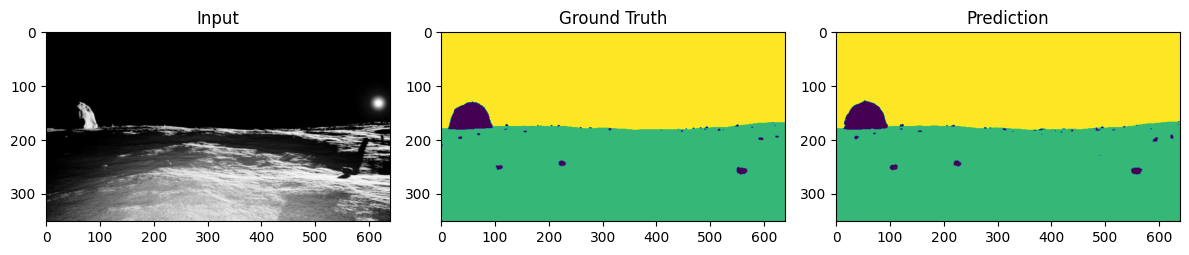

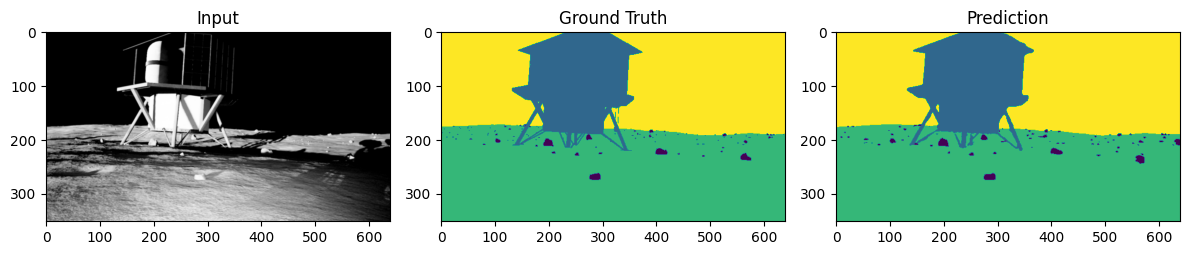

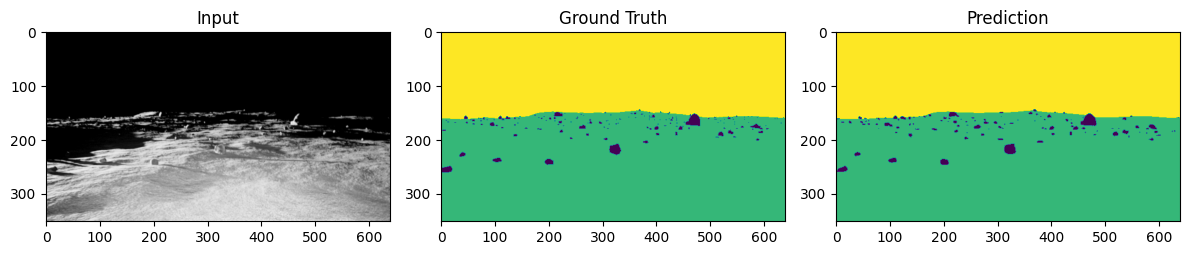

In [66]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    
    for i in range(4):
        img, mask = test_loader.dataset[i]
        # img, mask = test_loader.dataset[len(test_loader.dataset) - 1 - i]
        img = img.to(device)
        out = model(img.unsqueeze(0))
        pred = out.argmax(1).squeeze().cpu()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.title("Input")
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze())
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.tight_layout()
        plt.show()


In [69]:
total_time = 0
for i in range(100):
    img, mask = test_loader.dataset[i]
    # img, mask = test_loader.dataset[len(test_loader.dataset) - 1 - i]
    img = img.to(device)
    tic = time.time()
    out = model(img.unsqueeze(0))
    toc = time.time()
    total_time += toc - tic
    pred = out.argmax(1).squeeze().cpu()

print(f"{total_time / 100:.4f} seconds per image")
print(100/total_time)

0.0026 seconds per image
385.56151944719966
